# Implementación con Adaptative Thresh mean

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_sauvola
from skimage import img_as_ubyte
from skimage.measure import label, regionprops
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import pandas as pd

def clean(filename, min_size=100):
    # Lee la imagen usando OpenCV
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Aplicar filtro de mediana
    threshold_value = 10  # Umbral para considerar valores muy negros
    img[img < threshold_value] = 255

    img_median = cv2.medianBlur(img, 5)
    img_thresh = cv2.adaptiveThreshold(img_median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Crear una máscara de los píxeles blancos en la imagen 1
    mascara_blancos = (img == 255).astype(np.uint8)

    # Aplicar dilatación a la máscara
    kernel = np.ones((5,5),np.uint8)  # Kernel de 5x5 para la dilatación
    mascara_blancos_dilatada = cv2.dilate(mascara_blancos, kernel, iterations=3)

    # Copiar los píxeles blancos de la imagen 1 dilatada a la imagen 2
    img_thresh[mascara_blancos_dilatada != 0] = 255

    # Invertir las imágenes
    img = 255 - img
    img_thresh = 255 - img_thresh

    # Crear una máscara de los píxeles blancos en la imagen binarizada
    mascara_blancos = (img_thresh == 255).astype(np.uint8)

    # Etiquetar componentes conectados
    labeled_img = label(mascara_blancos, background=0)
    # Obtener propiedades de las regiones etiquetadas
    regions = regionprops(labeled_img)

    # Crear una máscara para eliminar regiones pequeñas
    mask = np.zeros_like(img_thresh)
    for region in regions:
        if region.area >= min_size:
            mask[labeled_img == region.label] = 255

    # Aplicar la máscara
    img_thresh_cleaned = cv2.bitwise_and(img_thresh, mask)

    return img_thresh, img_thresh_cleaned

In [2]:
# Función para calcular especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)


metrics = []  # Lista para almacenar las métricas de cada imagen

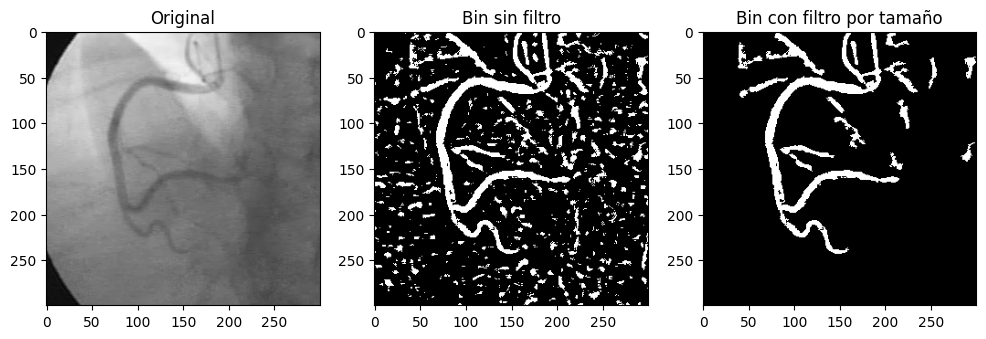

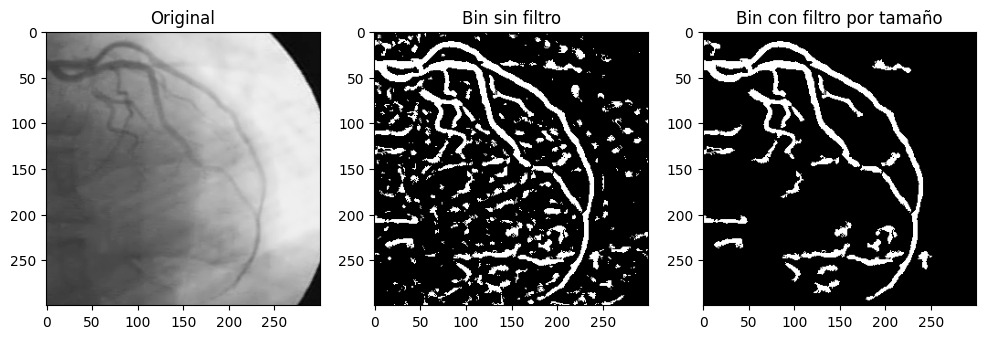

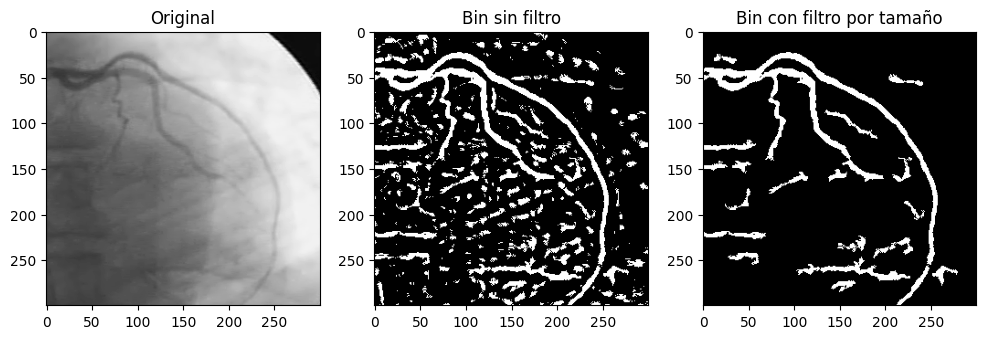

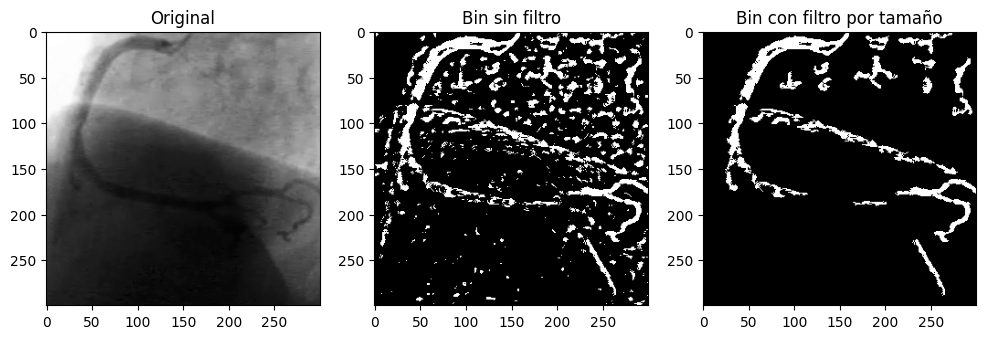

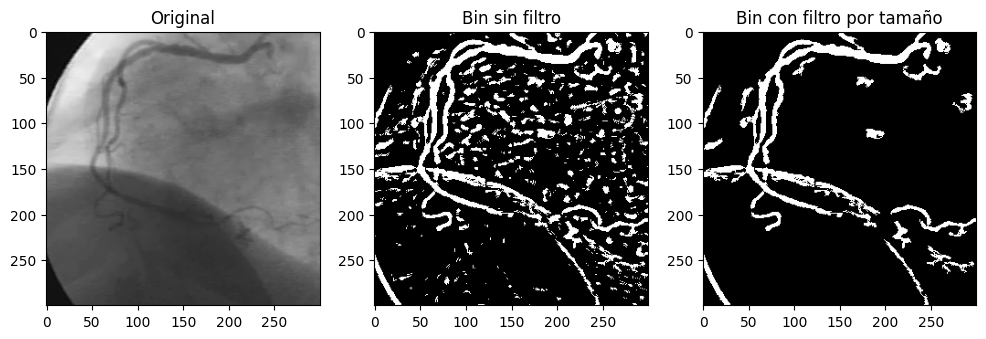

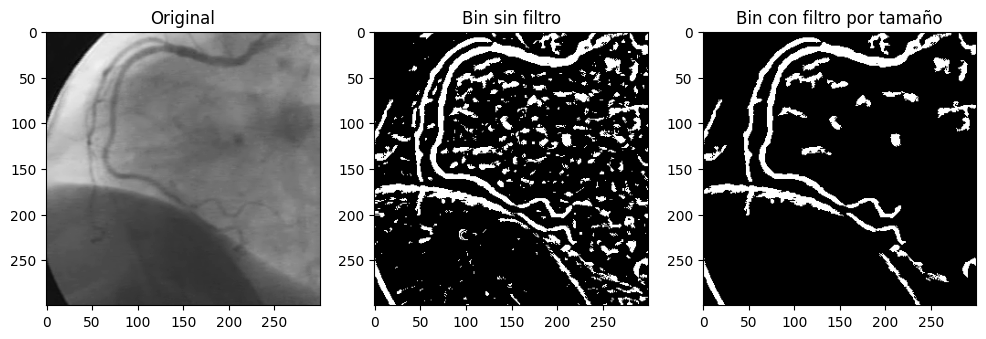

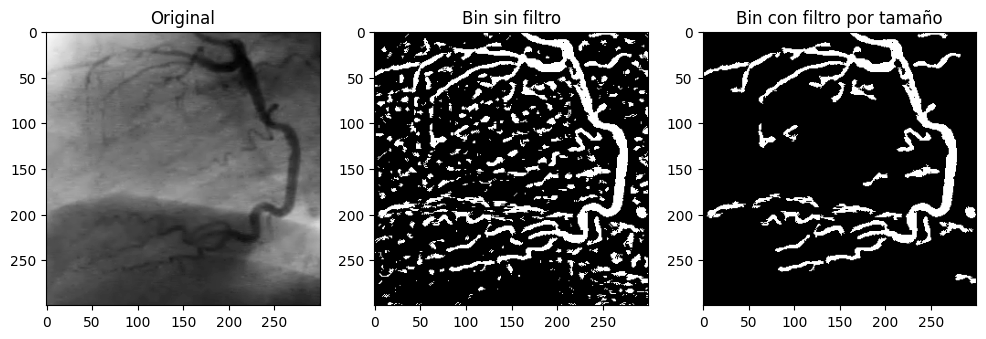

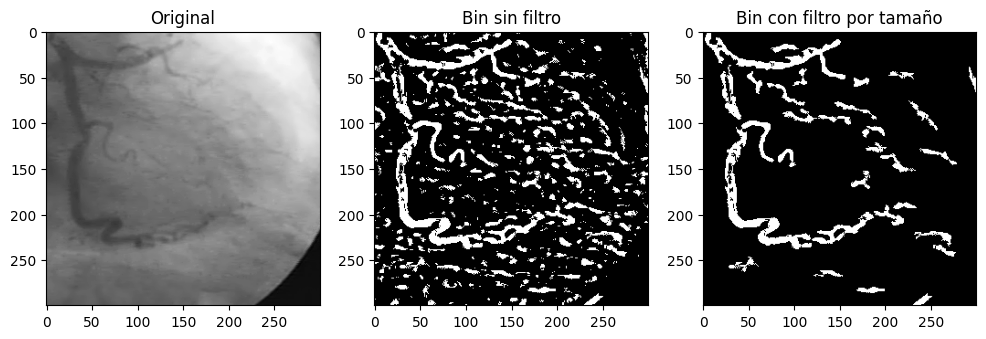

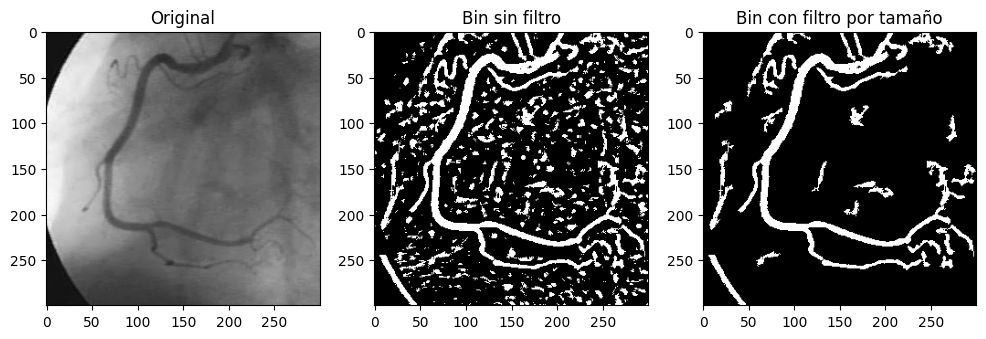

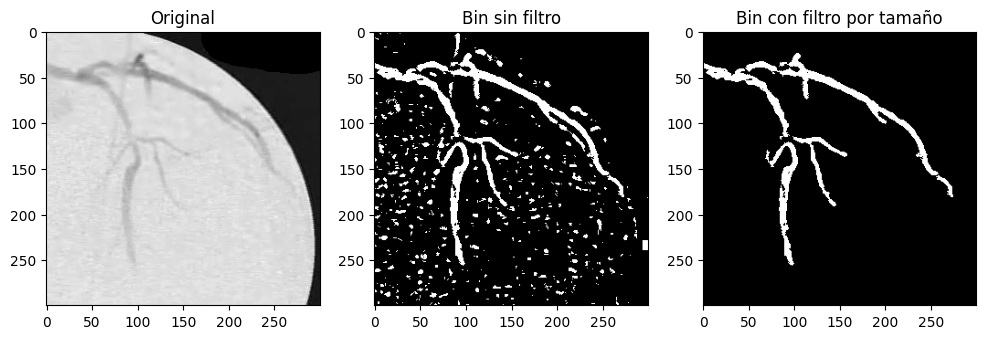

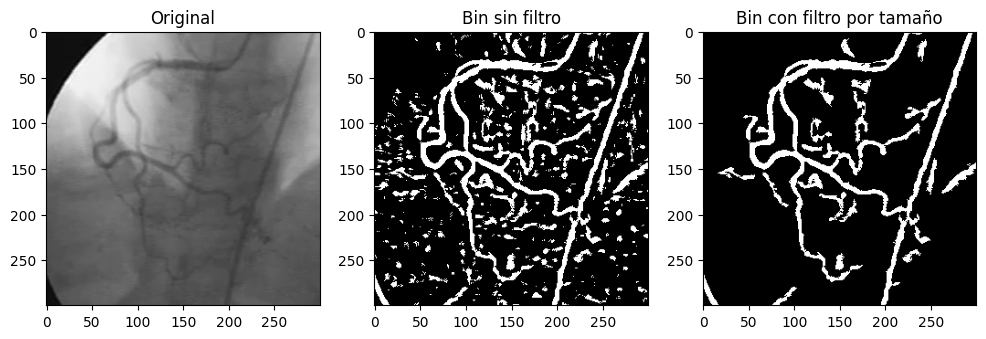

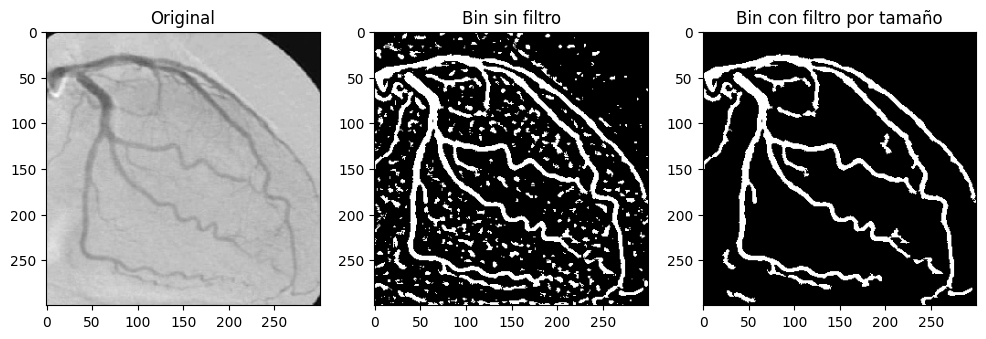

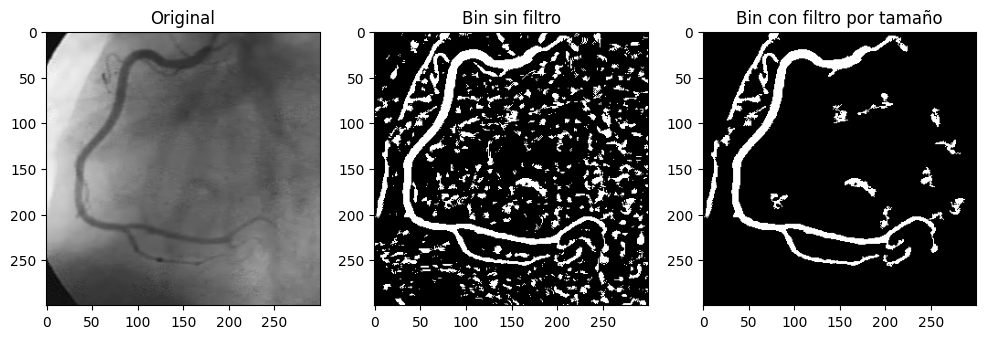

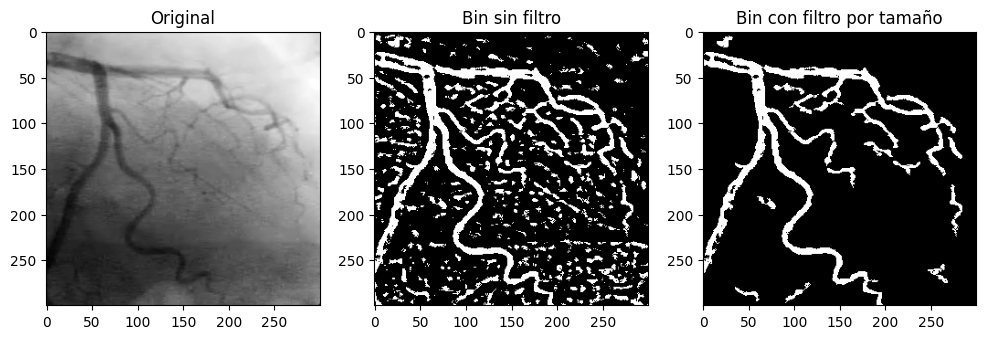

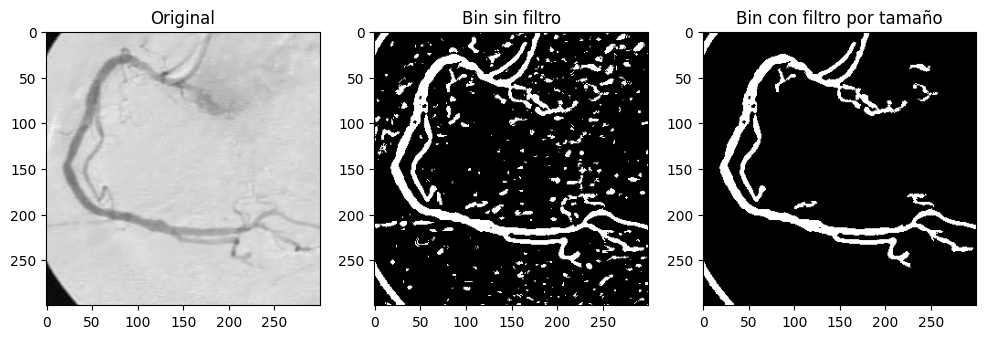

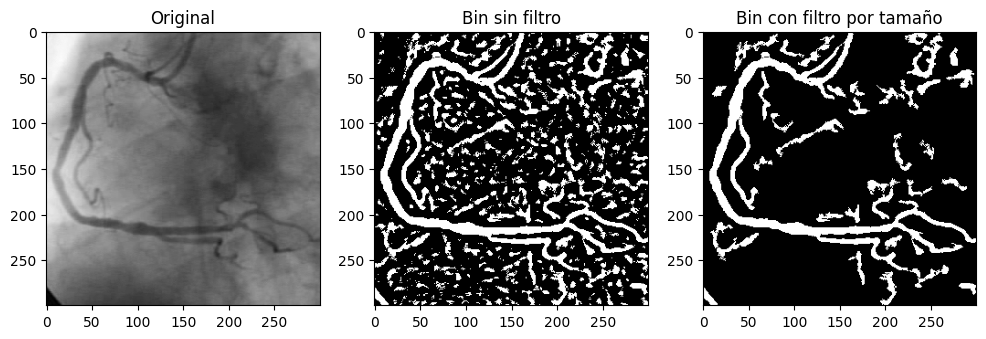

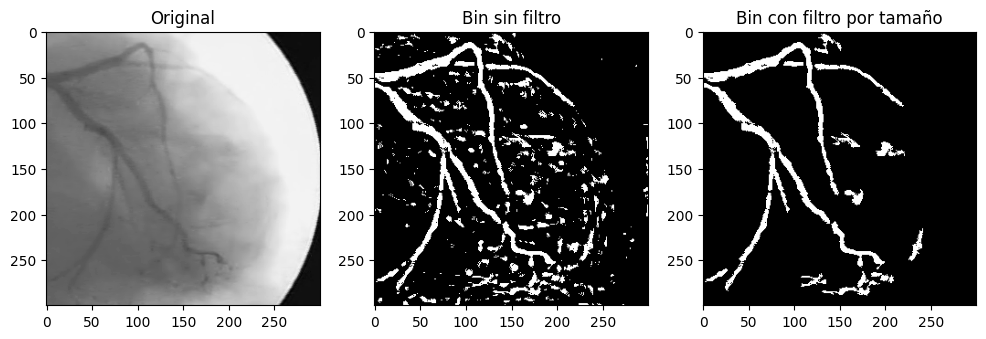

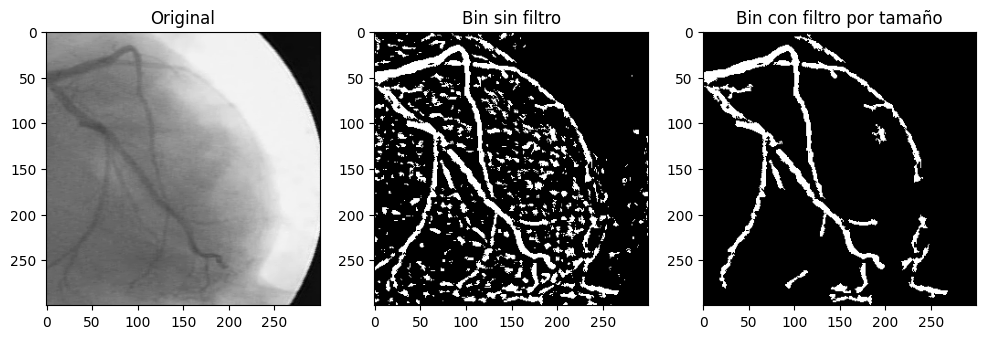

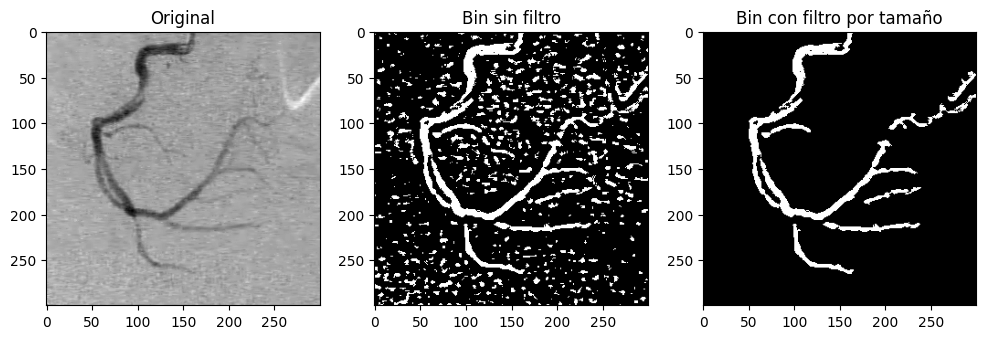

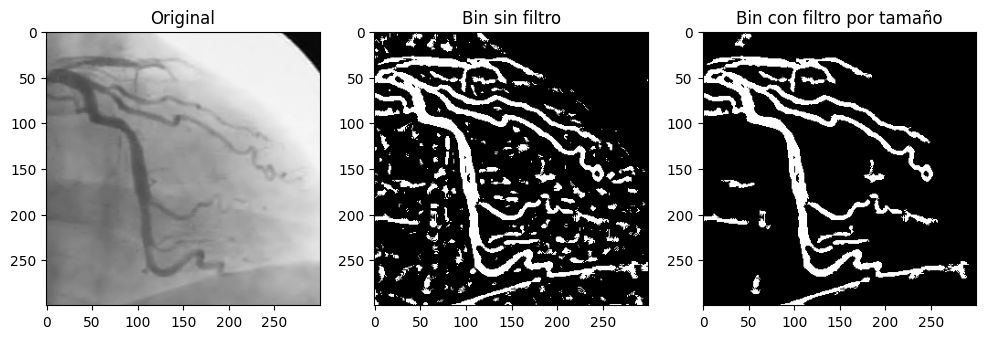

In [3]:
for n in range(1, 21):
    filename = f'images/{n}.pgm'
    img_thresh, img_thresh_cleaned = clean(filename)

        # Carga de la imagen de referencia y binarización
    img_gt = cv2.imread(f'images/{n}_gt.pgm', cv2.IMREAD_GRAYSCALE)
    _, img_gt_binary = cv2.threshold(img_gt, 127, 1, cv2.THRESH_BINARY)

    # Asegurarse de que img_thresh_cleaned esté en el formato correcto (binario 0 y 1)
    _, img_thresh_cleaned_binary = cv2.threshold(img_thresh_cleaned, 127, 1, cv2.THRESH_BINARY)

    # Cálculo de métricas
    accuracy = accuracy_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    sensitivity = recall_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    spec = specificity(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    precision = precision_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    f1 = f1_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())

    metrics.append([accuracy, sensitivity, spec, precision, f1])

    plt.figure(figsize=(12, 6))

    plt.subplot(131)
    plt.imshow(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original')

    plt.subplot(132)
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Bin sin filtro')

    plt.subplot(133)
    plt.imshow(img_thresh_cleaned, cmap='gray')
    plt.title('Bin con filtro por tamaño')

    plt.show()

In [4]:
# Creación de un DataFrame con las métricas
df_metrics = pd.DataFrame(metrics, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'])
# Calcula el promedio de las métricas
avg_metrics = df_metrics.mean()

# Agrega una nueva fila con los promedios al DataFrame
df_metrics.loc['Average'] = avg_metrics

# Imprime el DataFrame actualizado
print(df_metrics)

         Accuracy  Sensitivity  Specificity  Precision  F1 Score
0        0.948944     0.879397     0.951994   0.445472  0.591374
1        0.934111     0.941620     0.933739   0.413138  0.574300
2        0.937956     0.920871     0.938702   0.396162  0.553994
3        0.926756     0.615539     0.941144   0.325922  0.426184
4        0.925911     0.886022     0.927408   0.314127  0.463815
5        0.920722     0.903413     0.921377   0.303077  0.453884
6        0.924044     0.890519     0.925780   0.383159  0.535787
7        0.930933     0.744225     0.940071   0.378009  0.501364
8        0.925411     0.940214     0.924617   0.400912  0.562129
9        0.973433     0.833333     0.979861   0.654987  0.733475
10       0.909189     0.865337     0.911048   0.292035  0.436694
11       0.933578     0.884216     0.937827   0.550436  0.678498
12       0.943233     0.916201     0.944353   0.405489  0.562173
13       0.932811     0.815079     0.941894   0.519735  0.634733
14       0.949967     0.9

# Implementacion con Niblack adaptativo

In [5]:
def niblack_binarization(filename, window_size, k, min_size=300):

    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Convertir la imagen a escala de grises si es necesario
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplicar filtro de mediana
    threshold_value = 10  # Umbral para considerar valores muy negros
    img[img < threshold_value] = 255

    # Aplicar un filtro de mediana para reducir el ruido
    img_median = cv2.medianBlur(img.astype(np.float32), 5)

    # Calcular la media local utilizando un filtro de caja
    local_mean = cv2.boxFilter(img_median, -1, (window_size, window_size))

    # Calcular la desviación estándar local
    local_std = np.sqrt(cv2.boxFilter(img_median ** 2, -1, (window_size, window_size)) - local_mean ** 2)
    threshold = local_mean + k * local_std - 0.5

    # Binarizar la imagen
    binary_img = (img_median >= threshold).astype('uint8') * 255

     # Crear una máscara de los píxeles blancos en la imagen 1
    mascara_blancos = (img == 255).astype(np.uint8)

    # Aplicar dilatación a la máscara
    kernel = np.ones((5,5),np.uint8)  # Kernel de 5x5 para la dilatación
    mascara_blancos_dilatada = cv2.dilate(mascara_blancos, kernel, iterations=3)

    # Copiar los píxeles blancos de la imagen 1 dilatada a la imagen 2
    binary_img[mascara_blancos_dilatada != 0] = 255

    # Invertir las imágenes
    img = 255 - img
    binary_img = 255 - binary_img
    
    # Crear una máscara de los píxeles blancos en la imagen binarizada
    mascara_blancos = (binary_img == 255).astype(np.uint8)

    # Etiquetar componentes conectados
    labeled_img = label(mascara_blancos, background=0)
    # Obtener propiedades de las regiones etiquetadas
    regions = regionprops(labeled_img)

    # Crear una máscara para eliminar regiones pequeñas
    mask = np.zeros_like(binary_img)
    for region in regions:
        if region.area >= min_size:
            mask[labeled_img == region.label] = 255

    # Aplicar la máscara
    img_thresh_cleaned = cv2.bitwise_and(binary_img, mask)
    

    return binary_img, img_thresh_cleaned


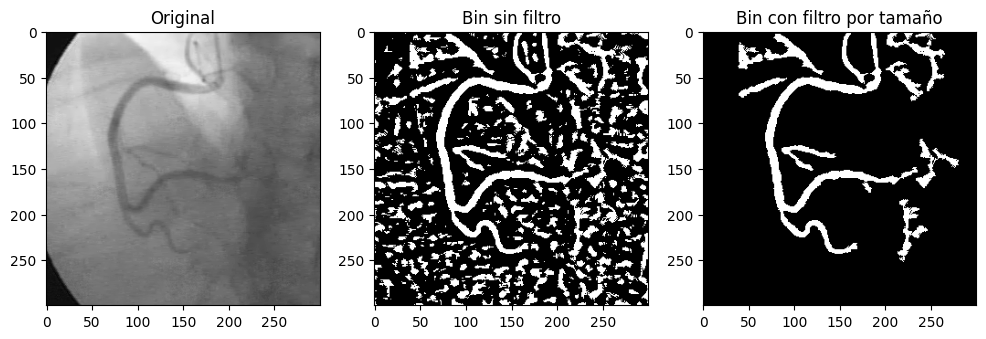

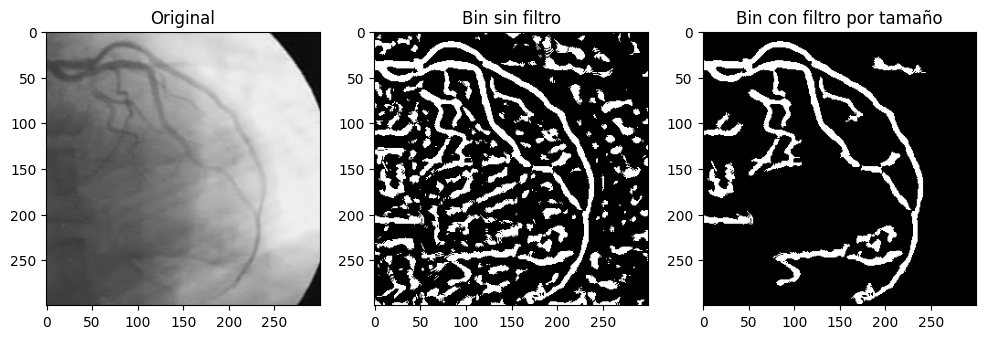

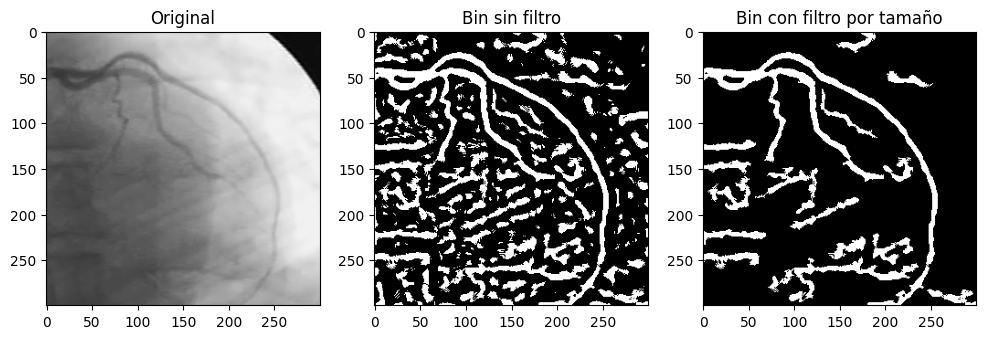

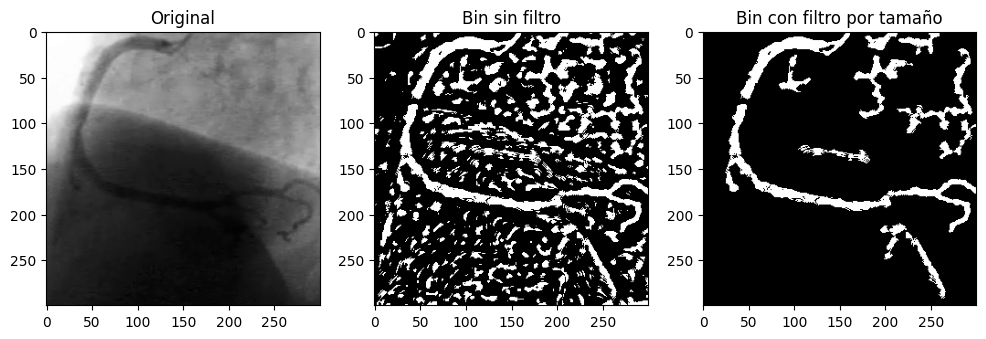

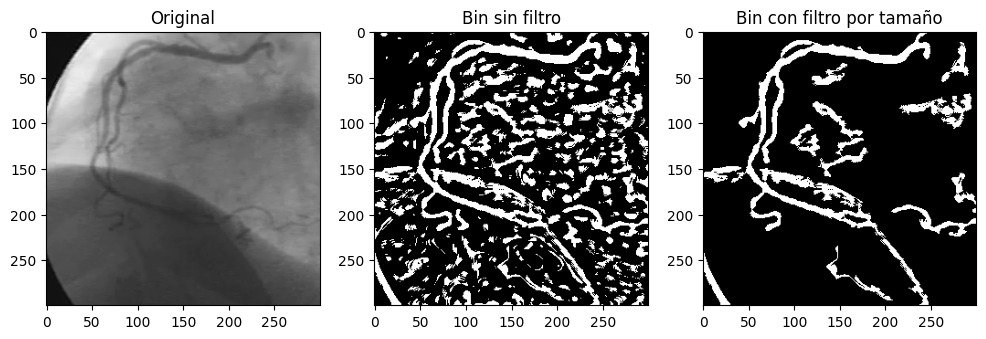

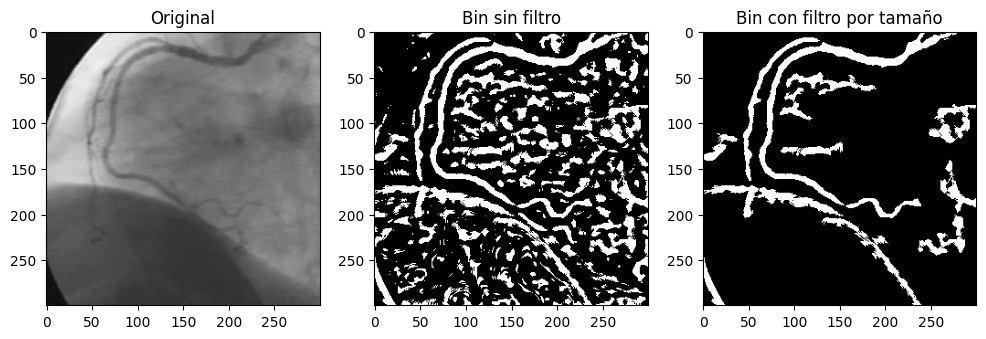

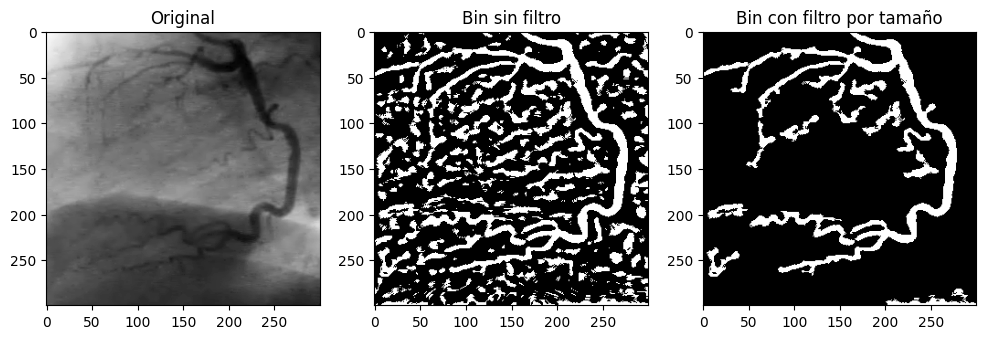

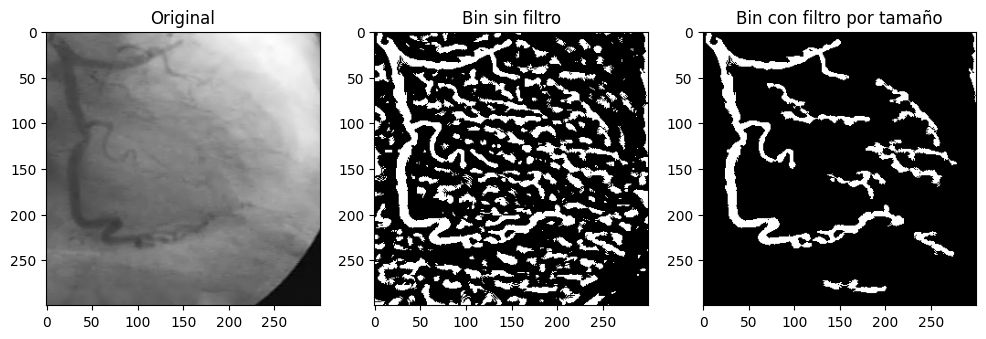

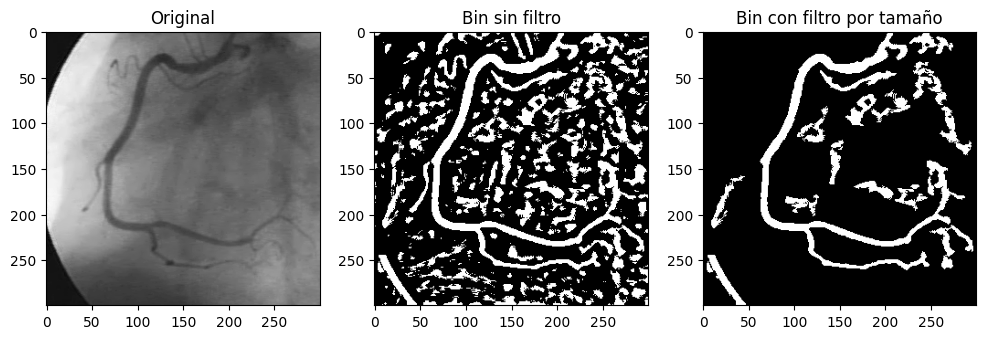

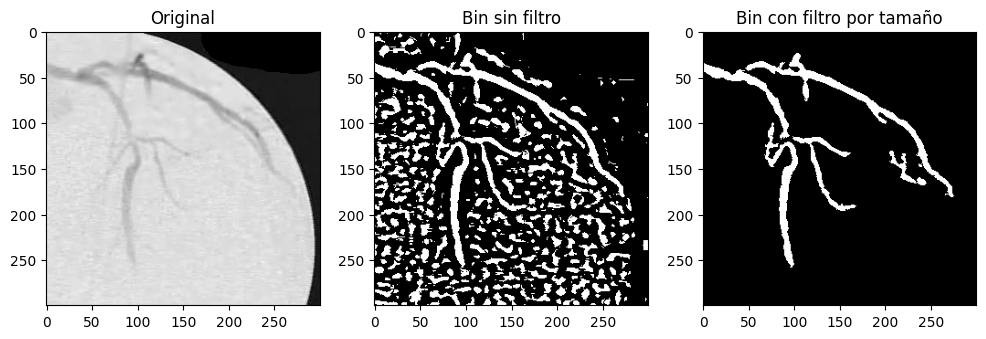

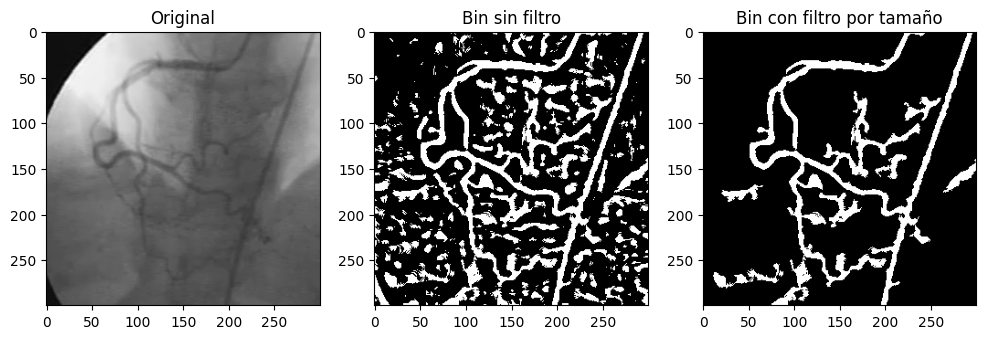

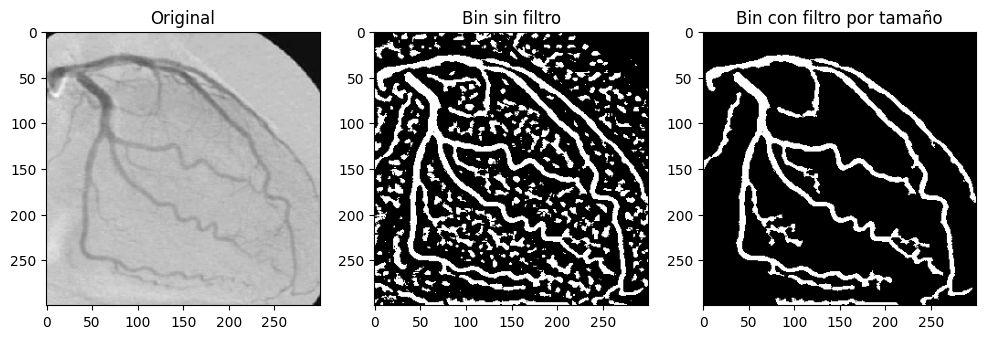

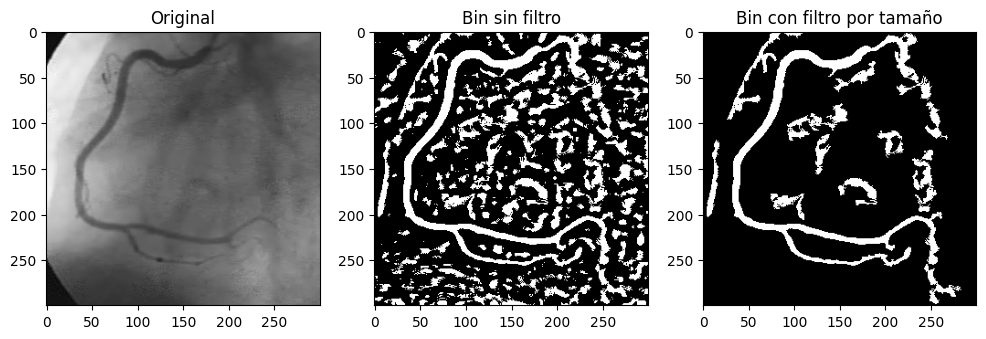

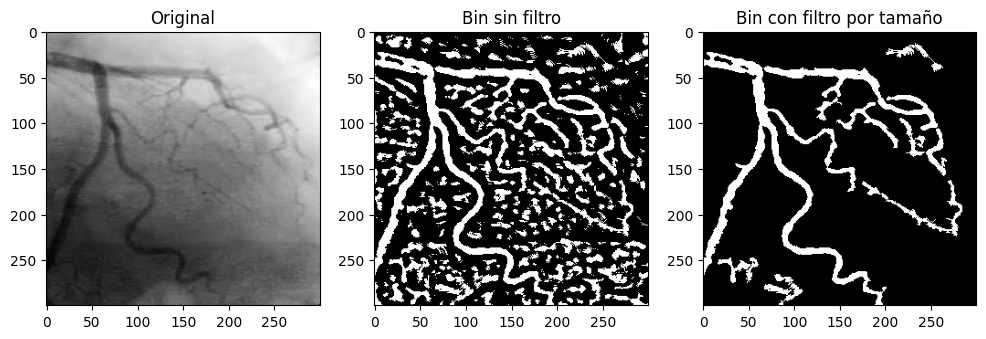

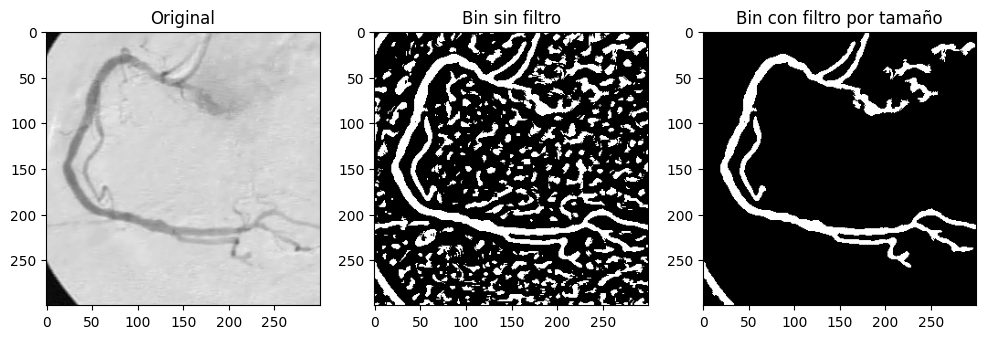

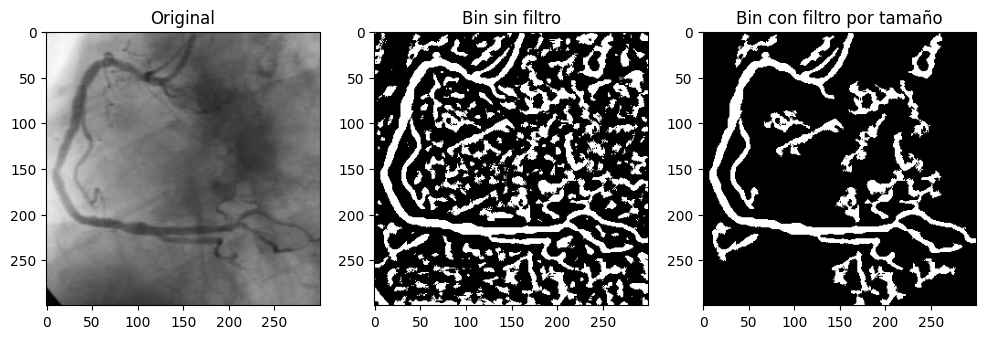

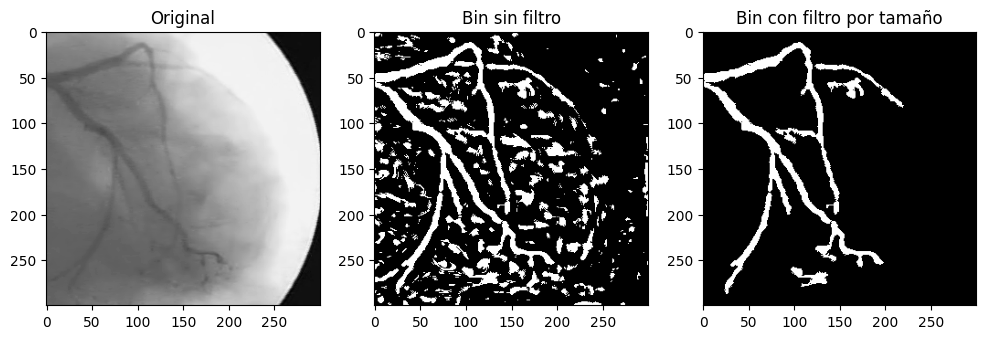

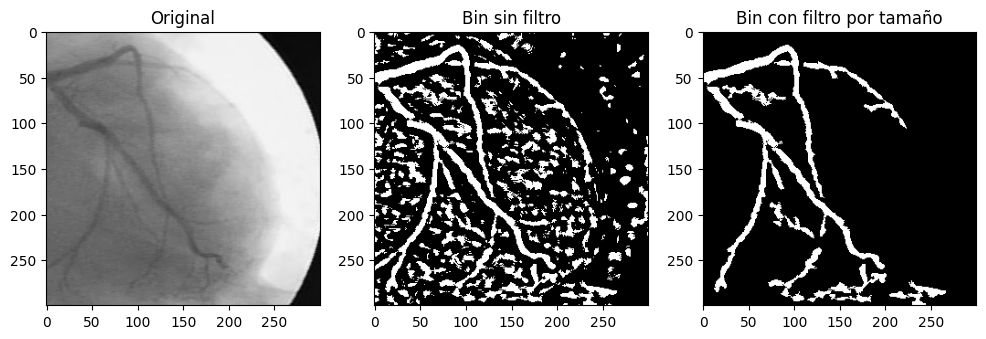

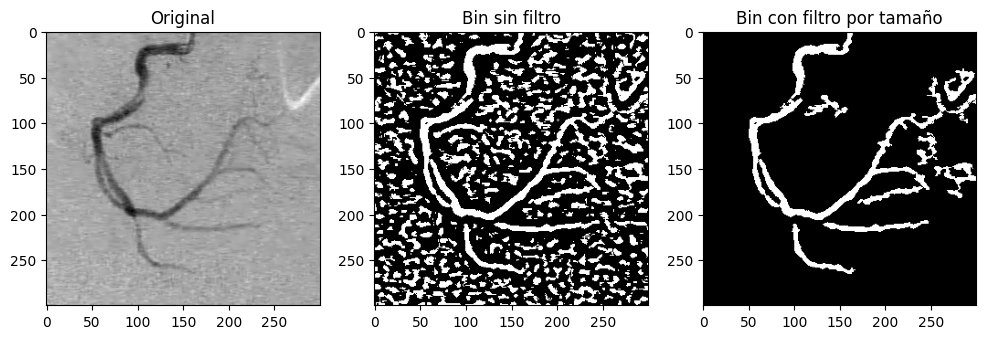

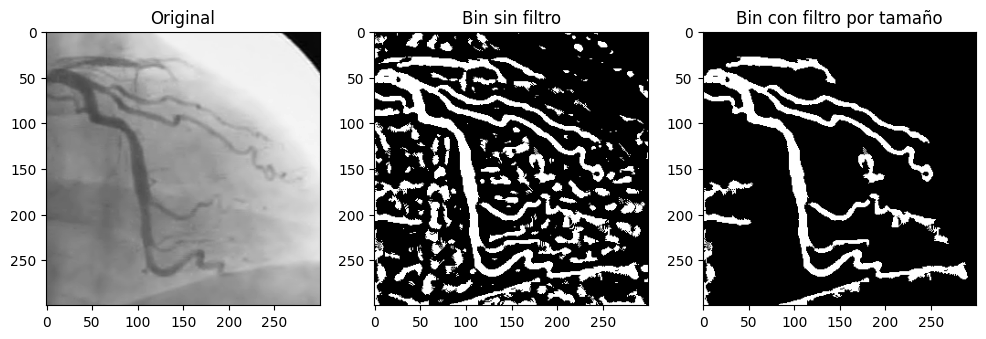

In [6]:
metrics = []

for n in range(1, 21):
    filename = f'images/{n}.pgm'
    img_thresh, img_thresh_cleaned = niblack_binarization(filename, window_size=15, k=-0.2)
    
    # Carga de la imagen de referencia y binarización
    img_gt = cv2.imread(f'images/{n}_gt.pgm', cv2.IMREAD_GRAYSCALE)
    _, img_gt_binary = cv2.threshold(img_gt, 127, 1, cv2.THRESH_BINARY)

    # Asegurarse de que img_thresh_cleaned esté en el formato correcto (binario 0 y 1)
    _, img_thresh_cleaned_binary = cv2.threshold(img_thresh_cleaned, 127, 1, cv2.THRESH_BINARY)

    # Cálculo de métricas
    accuracy = accuracy_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    sensitivity = recall_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    spec = specificity(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    precision = precision_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())
    f1 = f1_score(img_gt_binary.flatten(), img_thresh_cleaned_binary.flatten())

    metrics.append([accuracy, sensitivity, spec, precision, f1])

    # Visualización de las imágenes
    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original')
    plt.subplot(132)
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Bin sin filtro')
    plt.subplot(133)
    plt.imshow(img_thresh_cleaned, cmap='gray')
    plt.title('Bin con filtro por tamaño')
    plt.show()


In [7]:
# Creación de un DataFrame con las métricas
df_metrics = pd.DataFrame(metrics, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'])
# Calcula el promedio de las métricas
avg_metrics = df_metrics.mean()

# Agrega una nueva fila con los promedios al DataFrame
df_metrics.loc['Average'] = avg_metrics

# Imprime el DataFrame actualizado
print(df_metrics)

         Accuracy  Sensitivity  Specificity  Precision  F1 Score
0        0.934289     0.910870     0.935316   0.381776  0.538041
1        0.923044     0.936205     0.922392   0.374059  0.534543
2        0.893467     0.945035     0.891215   0.275039  0.426074
3        0.921322     0.852401     0.924509   0.342979  0.489142
4        0.901611     0.930261     0.900536   0.259780  0.406143
5        0.901300     0.856185     0.903007   0.250423  0.387506
6        0.908767     0.913318     0.908531   0.340773  0.496350
7        0.923856     0.880448     0.925980   0.367934  0.518986
8        0.902500     0.834606     0.906143   0.323003  0.465753
9        0.967211     0.881712     0.971134   0.583571  0.702310
10       0.889267     0.850587     0.890907   0.248464  0.384587
11       0.923556     0.896692     0.925868   0.510128  0.650300
12       0.902544     0.900000     0.902650   0.276923  0.423529
13       0.921267     0.832454     0.928118   0.471861  0.602312
14       0.947844     0.9

# Resultados

##### Adaptative Thresh mean (Average)
###### Accuracy:       0.935506
###### Sensitivity:    0.867245
###### Specificity:    0.938995
###### Precision:      0.436109
###### F1 Score:       0.572989

##### Niblack adaptativo (Average)
###### Accuracy:       0.919982
###### Sensitivity:    0.886606
###### Specificity:    0.921808
###### Precision:      0.383892
###### F1 Score:       0.527868

# Conclusión


                                                             
La aplicación de filtros post-binarización para limpiar imperfecciones en ambos algoritmos, Umbral Adaptativo y Niblack Adaptativo, indica una etapa crucial de postprocesamiento destinada a mejorar la calidad y la precisión de los resultados finales. Este paso es esencial para refinar los resultados de la binarización, eliminando artefactos y mejorando la claridad de la imagen o datos procesados.

El algoritmo de Umbral Adaptativo, con su mayor precisión global (Accuracy), especificidad (Specificity) y puntuación F1 (F1 Score), muestra un rendimiento superior después de la aplicación de estos filtros post-binarización. Esto sugiere que, además de su eficacia inicial en la clasificación o detección, el algoritmo se beneficia significativamente de la etapa de postprocesamiento para producir resultados más limpios y precisos. La superioridad en estas métricas indica que el algoritmo de Umbral Adaptativo es más robusto frente a las imperfecciones que inevitablemente surgen durante la binarización, y que los filtros aplicados posteriormente son efectivos en su minimización.

Aunque el Niblack Adaptativo presenta una sensibilidad superior, lo que indica una habilidad ligeramente mejor para identificar verdaderos positivos, su rendimiento en las otras métricas clave, especialmente en precisión (Precision) y puntuación F1, es inferior. Esto podría sugerir que, aunque es competente en la detección de elementos de interés, el Niblack Adaptativo podría beneficiarse de una revisión o mejora en los filtros post-binarización aplicados para abordar mejor las imperfecciones resultantes y mejorar su precisión y fiabilidad general.

En resumen, la aplicación de filtros post-binarización es una etapa crítica en el proceso de análisis de imágenes o datos, que tiene un impacto significativo en la calidad de los resultados finales. El algoritmo de Umbral Adaptativo demuestra un mejor rendimiento general después de esta etapa de limpieza, lo que lo hace más adecuado para aplicaciones que exigen alta precisión y confiabilidad. La elección del algoritmo y la estrategia de postprocesamiento deben considerarse cuidadosamente para maximizar la efectividad del procesamiento de imágenes o datos.
